# RNA, monosome and ribosome occupancy fold changes of NMD targets
### with counts from salmon mapping and fold changes by Xtail

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

Import Colombo et al. NMD targets (my own computations)

In [3]:
import pandas as pd
import pandas as pd

colombo_p_values = pd.read_csv('../3_call_NMD_targets/colombo_NMD_meta_pvalues.tsv', sep = '\t')
colombo_p_values.sort_values(by=['meta_meta'], inplace=True)

Import and combine xtail analysis results

In [4]:
#import and concatenate data
import pandas as pd
import numpy as np
import math
import os
columns = ['tx_id','mRNA_log2FC','RPF_log2FC','log2FC_TE_v1','pvalue_v1','nontargeting_log2TE','perturbation_log2TE','log2FC_TE_v2','pvalue_v2','log2FC_TE_final','pvalue_final','pvalue.adjust','dataset']
all_xtail = []

for file_name in os.listdir('../5_run_xtail/xtail_results/'):
    if file_name.endswith('tsv') and not file_name.startswith('.'):
        sample_name = file_name[6:-4]
        df = pd.read_csv(os.path.join('../5_run_xtail/xtail_results/', file_name), sep='\t')
        df['dataset'] = sample_name
        df.columns = columns
        all_xtail.append(df)

combined_xtail_results = pd.concat(all_xtail, sort=False)

Plot mRNA and monosome and disome fold changes

In [5]:
#set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
# Say, "the default sans-serif font is arial"
mpl.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"
##plot CDF or mRNA RPKMs
black = (0,0,0)
gray = (0.5,0.5,0.5)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [blue, orange, bluishGreen, black, skyBlue, vermillion, reddishPurple, yellow]
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']

In [6]:
import sys
pipeline_dir = '../ribo_seq/'
if pipeline_dir not in sys.path:
    sys.path.append(pipeline_dir)
import ribo_utils

In [7]:
comprehensive_gtf_data = ribo_utils.gtf_data('../annotations/gencode.v35.annotation.pBZ105.no_nonstop.gtf', add_3_for_stop=True)

In [8]:
"""
GENCODE's definition of nonsense_mediated_decay
If the coding sequence (following the appropriate reference) of a transcript finishes >50bp
from a downstream splice site then it is tagged as NMD. If the variant does not cover the 
full reference coding sequence then it is annotated as NMD if NMD is unavoidable 
i.e. no matter what the exon structure of the missing portion is the transcript will be subject to NMD.
"""
def get_nmd_status_any(x):
    if '|' in x:
        return any([get_nmd_status_any(tx) for tx in x.split('|')])
    return sorted(comprehensive_gtf_data.transcript_to_entries[x])[0].get_value('transcript_type') == 'nonsense_mediated_decay'

def get_nmd_status_all(x):
    if '|' in x:
        return all([get_nmd_status_all(tx) for tx in x.split('|')])
    return sorted(comprehensive_gtf_data.transcript_to_entries[x])[0].get_value('transcript_type') == 'nonsense_mediated_decay'

def get_gene_id(x):
    if '|' in x:
        return get_gene_id(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_genes[x]

def get_gene_name(x):
    if '|' in x:
        return get_gene_name(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_gene_names[x]

def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

combined_xtail_results['has dEJC'] = combined_xtail_results['tx_id'].apply(get_nmd_status_any)
#combined_xtail_results['all have dEJC'] = combined_xtail_results['tx_id'].apply(get_nmd_status_all)

In [9]:
#combined_xtail_results.replace([np.inf, -np.inf], np.nan)
#combined_xtail_results=combined_xtail_results.dropna()

In [10]:
dataset_group = combined_xtail_results.groupby('dataset')
for dataset in combined_xtail_results['dataset'].unique():
    df = dataset_group.get_group(dataset)
    df_in_columbo = df[df['tx_id'].isin(colombo_p_values['tx_id'])]
    print(dataset, len(df), len(df_in_columbo))
#df_in_columbo

('GIGYF2_in_SMG1i_mono_RNA', 10925, 9551)
('GIGYF2_in_DMSO_mono_RNA', 10320, 9255)
('SMG1i_mono_RNA', 10120, 9058)
('eIF4E2_in_DMSO_mono_RNA', 10742, 9539)
('eIF4E2_in_SMG1i_mono_RNA', 10876, 9543)
('GIGYF2_SMG1i_v_WT_mono_RNA', 10914, 9599)
('eIF4E2_SMG1i_v_WT_mono_RNA', 10831, 9591)


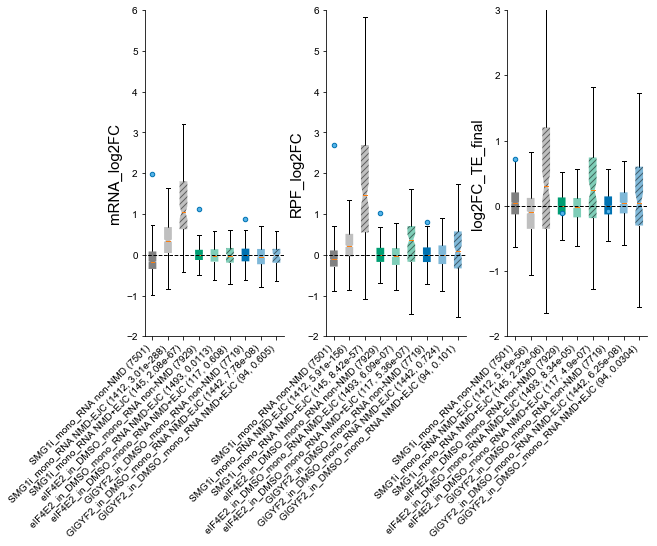

In [11]:
#plot fold changes for each dataset in same plot, single EJC cutoff, groups do not overlap
variables_to_plot = ['mRNA_log2FC', 'RPF_log2FC', 'log2FC_TE_final']
p = .05
datasets = ['SMG1i_mono_RNA', 'eIF4E2_in_DMSO_mono_RNA', 'GIGYF2_in_DMSO_mono_RNA']
#collect transcripts common to all datasets
dataset_group = combined_xtail_results.groupby('dataset')
dataset = datasets[0]
df = dataset_group.get_group(dataset)
tx_overlap = set(df.dropna()['tx_id'])
for dataset in datasets:
    df = dataset_group.get_group(dataset)
    tx_overlap = tx_overlap.intersection(set(df.dropna()['tx_id']))

plot_colors = [gray, bluishGreen, blue, reddishPurple, vermillion]


plot_index = 1
num_plots_wide = len(variables_to_plot)
num_plots_high = 1
fig = plt.figure(figsize=(3*num_plots_wide, 6*num_plots_high))

colombo_nmd_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
plots = []
for variable_to_plot in variables_to_plot:
    color_index = 0
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    plots.append(plot)
    box_data = []
    box_colors = []
    box_labels = []
    reporter_data = []
    for dataset in datasets:  
        
        #first assemble dataframes for 3 groups: non-NMD targets, colombo NMD targets, colombo NMD targets with EJC
        df = dataset_group.get_group(dataset)
        #df = df[df['tx_id'].isin(tx_overlap)] #only use transcripts with data in all datasets
        all_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=1]
        all_df = df[df['tx_id'].isin(all_colombo_tx['tx_id'])]
        #filter for NMD hits by p value
        nmd_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=p]
        nmd_df = all_df[all_df['tx_id'].isin(nmd_colombo_tx['tx_id'])]
        #filter for colombo targets with EJC
        ejc_tx = colombo_p_values[colombo_p_values['GENCODE nmd annotation']]
        nmd_EJC_df = nmd_df[nmd_df['tx_id'].isin(ejc_tx['tx_id'])]
        #remove NMD targets from "All":
        non_nmd_df = all_df[~all_df['tx_id'].isin(nmd_df['tx_id'])]
        #remove tx with EJC from non-EJC NMD df
        no_ejc_nmd_df = nmd_df[~nmd_df['tx_id'].isin(nmd_EJC_df['tx_id'])]
        
        #append boxplot data and p values to lists
        box_data.append(non_nmd_df[variable_to_plot])
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s non-NMD (%d)' %(dataset, len(non_nmd_df[variable_to_plot].dropna())))
        
        reporter_data.append(df[df['tx_id']=='UGAC_reporter'][variable_to_plot].tolist()[0])
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), no_ejc_nmd_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(no_ejc_nmd_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s NMD-EJC (%d, %.3g)' %(dataset, len(no_ejc_nmd_df[variable_to_plot].dropna()), mwp))
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), nmd_EJC_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(nmd_EJC_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s NMD+EJC (%d, %.3g)' %(dataset, len(nmd_EJC_df[variable_to_plot].dropna()), mwp))
        color_index+=1
        
    bp = plot.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False, notch=True,)
    
    # fill with colors
    i = 0
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set(linewidth=0)
        if i%3 > 0:
            patch.set_alpha(0.5)
        if i%3 == 2:
            patch.set_hatch('////')
        i += 1
    #draw line at median
    for i in range(0,3*len(datasets), 3):
        mean = np.median(box_data[i])
        #plot.hlines(mean, i+0.75, i+3.25, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.hlines(0, 0, 3*len(datasets)+1, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.scatter(range(1,3*len(datasets)+1,3), reporter_data, color=skyBlue, edgecolor=blue, s=20, zorder=11)
    #plot.set_xlabel(variable_to_plot)
    plot.set_ylabel(variable_to_plot, fontsize=15)
    #plot.set_title('NMD p = %.3g' %(p))
    #plot.set_ylim(0, 1.01)
    #if variable_to_plot == 'log2FC_TE_final':
    #    plot.set_xlim(-2, 2)
    #else:
    #plot.set_xlim(-1, 1)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    plt.xticks(rotation=45, ha='right')
    plot_index += 1
    #lg=plot.legend(loc=4,prop={'size':12}, labelspacing=0.2)
    #lg.draw_frame(False)
plots[0].set_ylim(-2, 6)
plots[1].set_ylim(-2, 6)
plots[2].set_ylim(-2, 3)

plt.subplots_adjust(wspace = 0.3)
#plt.tight_layout()
plt.savefig('NMD_%.2f_EJC_boxplots.pdf' %(p), transparent='True', format='pdf', bbox_inches='tight')

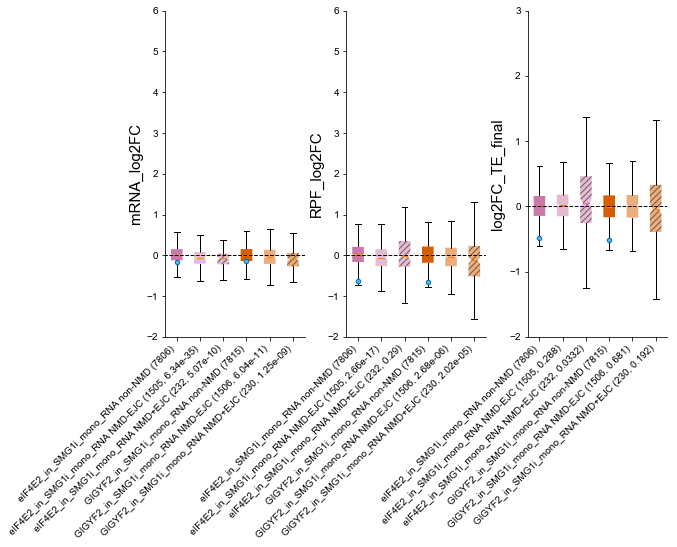

In [12]:
#plot fold changes for each dataset in same flot, single EJC cutoff, groups do not overlap
variables_to_plot = ['mRNA_log2FC', 'RPF_log2FC', 'log2FC_TE_final']
p = .05
datasets = ['eIF4E2_in_SMG1i_mono_RNA', 'GIGYF2_in_SMG1i_mono_RNA']
#collect transcripts common to all datasets
dataset_group = combined_xtail_results.groupby('dataset')
dataset = datasets[0]
df = dataset_group.get_group(dataset)
tx_overlap = set(df.dropna()['tx_id'])
for dataset in datasets:
    df = dataset_group.get_group(dataset)
    tx_overlap = tx_overlap.intersection(set(df.dropna()['tx_id']))

plot_colors = [gray, bluishGreen, blue, reddishPurple, vermillion]


plot_index = 1
num_plots_wide = len(variables_to_plot)
num_plots_high = 1
fig = plt.figure(figsize=(3*num_plots_wide, 6*num_plots_high))

colombo_nmd_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
plots = []
for variable_to_plot in variables_to_plot:
    color_index = 3
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    plots.append(plot)
    box_data = []
    box_colors = []
    box_labels = []
    reporter_data = []
    for dataset in datasets:  
        
        #first assemble dataframes for 3 groups: non-NMD targets, colombo NMD targets, colombo NMD targets with EJC
        df = dataset_group.get_group(dataset)
        #df = df[df['tx_id'].isin(tx_overlap)] #only use transcripts with data in all datasets
        all_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=1]
        all_df = df[df['tx_id'].isin(all_colombo_tx['tx_id'])].dropna()
        #filter for NMD hits by p value
        nmd_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=p]
        nmd_df = all_df[all_df['tx_id'].isin(nmd_colombo_tx['tx_id'])]
        #filter for colombo targets with EJC
        ejc_tx = colombo_p_values[colombo_p_values['GENCODE nmd annotation']]
        nmd_EJC_df = nmd_df[nmd_df['tx_id'].isin(ejc_tx['tx_id'])]
        #remove NMD targets from "All":
        non_nmd_df = all_df[~all_df['tx_id'].isin(nmd_df['tx_id'])]
        #remove tx with EJC from non-EJC NMD df
        no_ejc_nmd_df = nmd_df[~nmd_df['tx_id'].isin(nmd_EJC_df['tx_id'])]
        
        #append boxplot data and p values to lists
        box_data.append(non_nmd_df[variable_to_plot])
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s non-NMD (%d)' %(dataset, len(non_nmd_df[variable_to_plot].dropna())))
        
        reporter_data.append(df[df['tx_id']=='UGAC_reporter'][variable_to_plot].tolist()[0])
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), no_ejc_nmd_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(no_ejc_nmd_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s NMD-EJC (%d, %.3g)' %(dataset, len(no_ejc_nmd_df[variable_to_plot].dropna()), mwp))
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), nmd_EJC_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(nmd_EJC_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index])
        box_labels.append('%s NMD+EJC (%d, %.3g)' %(dataset, len(nmd_EJC_df[variable_to_plot].dropna()), mwp))
        color_index+=1
        
    bp = plot.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False, notch=True,)
    
    # fill with colors
    i = 0
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set(linewidth=0)
        if i%3 > 0:
            patch.set_alpha(0.5)
        if i%3 == 2:
            patch.set_hatch('////')
        i += 1
    #draw line at median
    for i in range(0,3*len(datasets), 3):
        mean = np.median(box_data[i])
        #plot.hlines(mean, i+0.75, i+3.25, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.hlines(0, 0, 3*len(datasets)+1, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.scatter(range(1,3*len(datasets)+1,3), reporter_data, color=skyBlue, edgecolor=blue, s=20, zorder=11)
    #plot.set_xlabel(variable_to_plot)
    plot.set_ylabel(variable_to_plot, fontsize=15)
    #plot.set_title('NMD p = %.3g' %(p))
    #plot.set_ylim(0, 1.01)
    #if variable_to_plot == 'log2FC_TE_final':
    #    plot.set_xlim(-2, 2)
    #else:
    #plot.set_xlim(-1, 1)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    plt.xticks(rotation=45, ha='right')
    plot_index += 1
    #lg=plot.legend(loc=4,prop={'size':12}, labelspacing=0.2)
    #lg.draw_frame(False)
plots[0].set_ylim(-2, 6)
plots[1].set_ylim(-2, 6)
plots[2].set_ylim(-2, 3)
plt.subplots_adjust(wspace = 0.3)
#plt.tight_layout()
plt.savefig('NMD_%.2f_EJC_boxplots_SMG1i.pdf' %(p), transparent='True', format='pdf', bbox_inches='tight')